In [1]:
import plot
from scipy.special import logit
from shap.maskers import Independent
from sklearn.utils import resample
import shap
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
%matplotlib inline
shap.initjs()

In [2]:
with open('dataset.pickle', 'rb') as f:
    X, y, display_data = pickle.load(f)
with open('classifiers.pickle', 'rb') as f:
    clf_a, clf_b = pickle.load(f)

In [3]:
try:
    with open(f'shapvalues.soa.proba.pickle', 'rb') as f:
        shap_proba_a, shap_proba_b, shap_proba_a_vs_b, feature_order = pickle.load(f)
        print('Loaded cached shap values')
except FileNotFoundError:
    print('No cached shap values found')

Loaded cached shap values


In [4]:
feature_names = np.array(X.columns)
n_features = len(feature_names)
n_samples = X.shape[0]

First, we take a sample of the dataset to reduce calculation time

In [5]:
background_data = X
X_explain, display_data_explain = resample(X, display_data, n_samples=375, replace=False, random_state=0)

In [6]:
with open('dataset.soa.explain.pickle', 'wb') as f:
    pickle.dump((background_data, X_explain, display_data_explain), f, pickle.HIGHEST_PROTOCOL)

Now we define the functions to be explained:

In [7]:
predict_proba_a = lambda X: clf_a.predict_proba(X)[:, 1]
predict_proba_b = lambda X: clf_b.predict_proba(X)[:, 1]

And now we calculate SHAP values for each function:

In [8]:
def explain(predict, background_data):
    masker = Independent(data=background_data)
    explainer = shap.Explainer(predict, masker, feature_names=feature_names)
    shap_values = explainer(X_explain)
    shap_values.display_data = display_data_explain
    return shap_values

In [9]:
%%time
shap_proba_a = explain(predict_proba_a, background_data)
shap_proba_b = explain(predict_proba_b, background_data)

shap_proba_a_vs_b = shap_proba_b - shap_proba_a
shap_proba_a_vs_b.data = shap_proba_a.data
shap_proba_a_vs_b.display_data = shap_proba_a.display_data

feature_order = np.flip(shap_proba_a_vs_b.abs.mean(axis=0).values.argsort())

with open(f'shapvalues.soa.proba.pickle', 'wb') as f:
    pickle.dump((shap_proba_a, shap_proba_b, shap_proba_a_vs_b, feature_order), f, pickle.HIGHEST_PROTOCOL)

Permutation explainer: 376it [00:18, 12.89it/s]                         
Permutation explainer: 376it [00:10,  1.91it/s]                         


CPU times: user 41.3 s, sys: 3.58 s, total: 44.9 s
Wall time: 30 s


## Analyze

### Feature Importance

We estimate it with the mean absolute SHAP value (which is the default for this plot) and will also sort features subsequently in this order

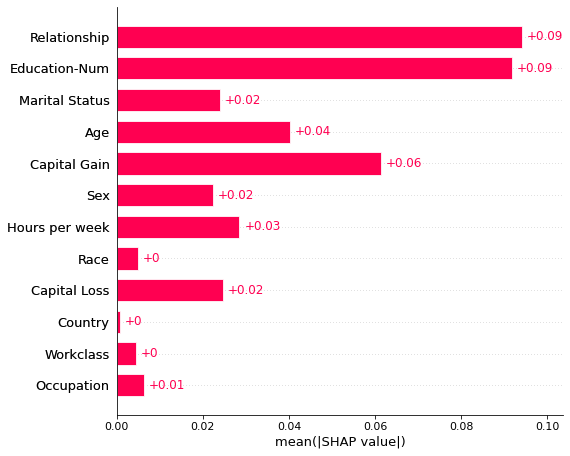

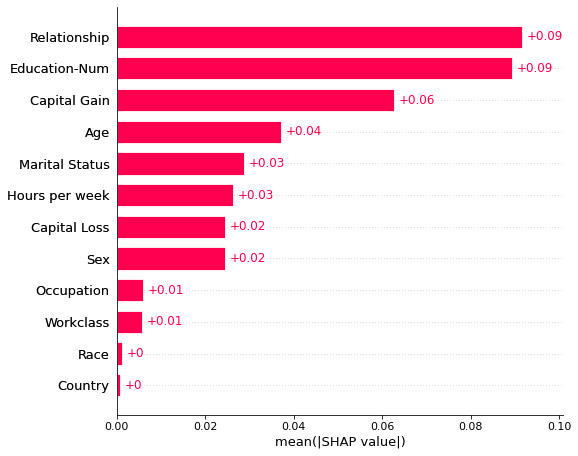

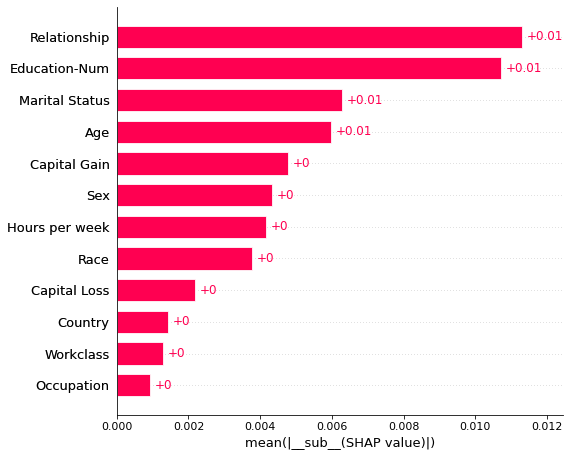

In [5]:
shap.plots.bar(shap_proba_a, order=feature_order, max_display=n_features)
shap.plots.bar(shap_proba_b, max_display=n_features)
shap.plots.bar(shap_proba_a_vs_b, order=feature_order, max_display=n_features)

### SHAP Value Distribution

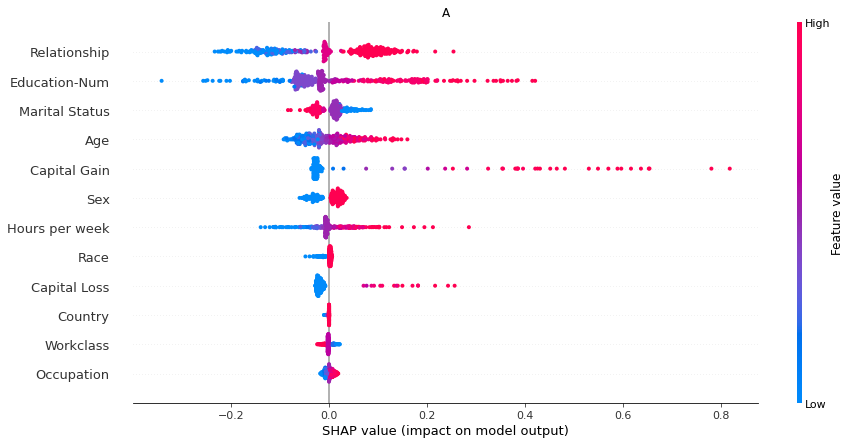

In [6]:
plot.shap_beeswarm(shap_proba_a, 'A', order=feature_order, max_display=n_features)

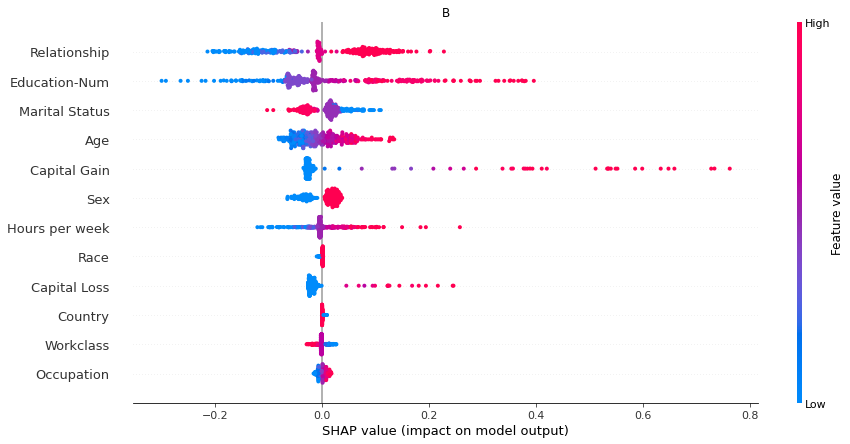

In [7]:
plot.shap_beeswarm(shap_proba_b, 'B', order=feature_order, max_display=n_features)

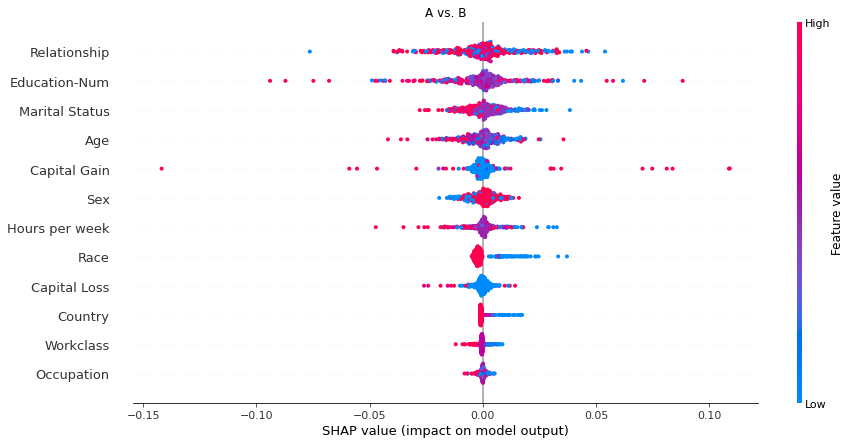

In [8]:
plot.shap_beeswarm(shap_proba_a_vs_b, 'A vs. B', order=feature_order, max_display=n_features)

### Features' Partial Dependence Plots

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


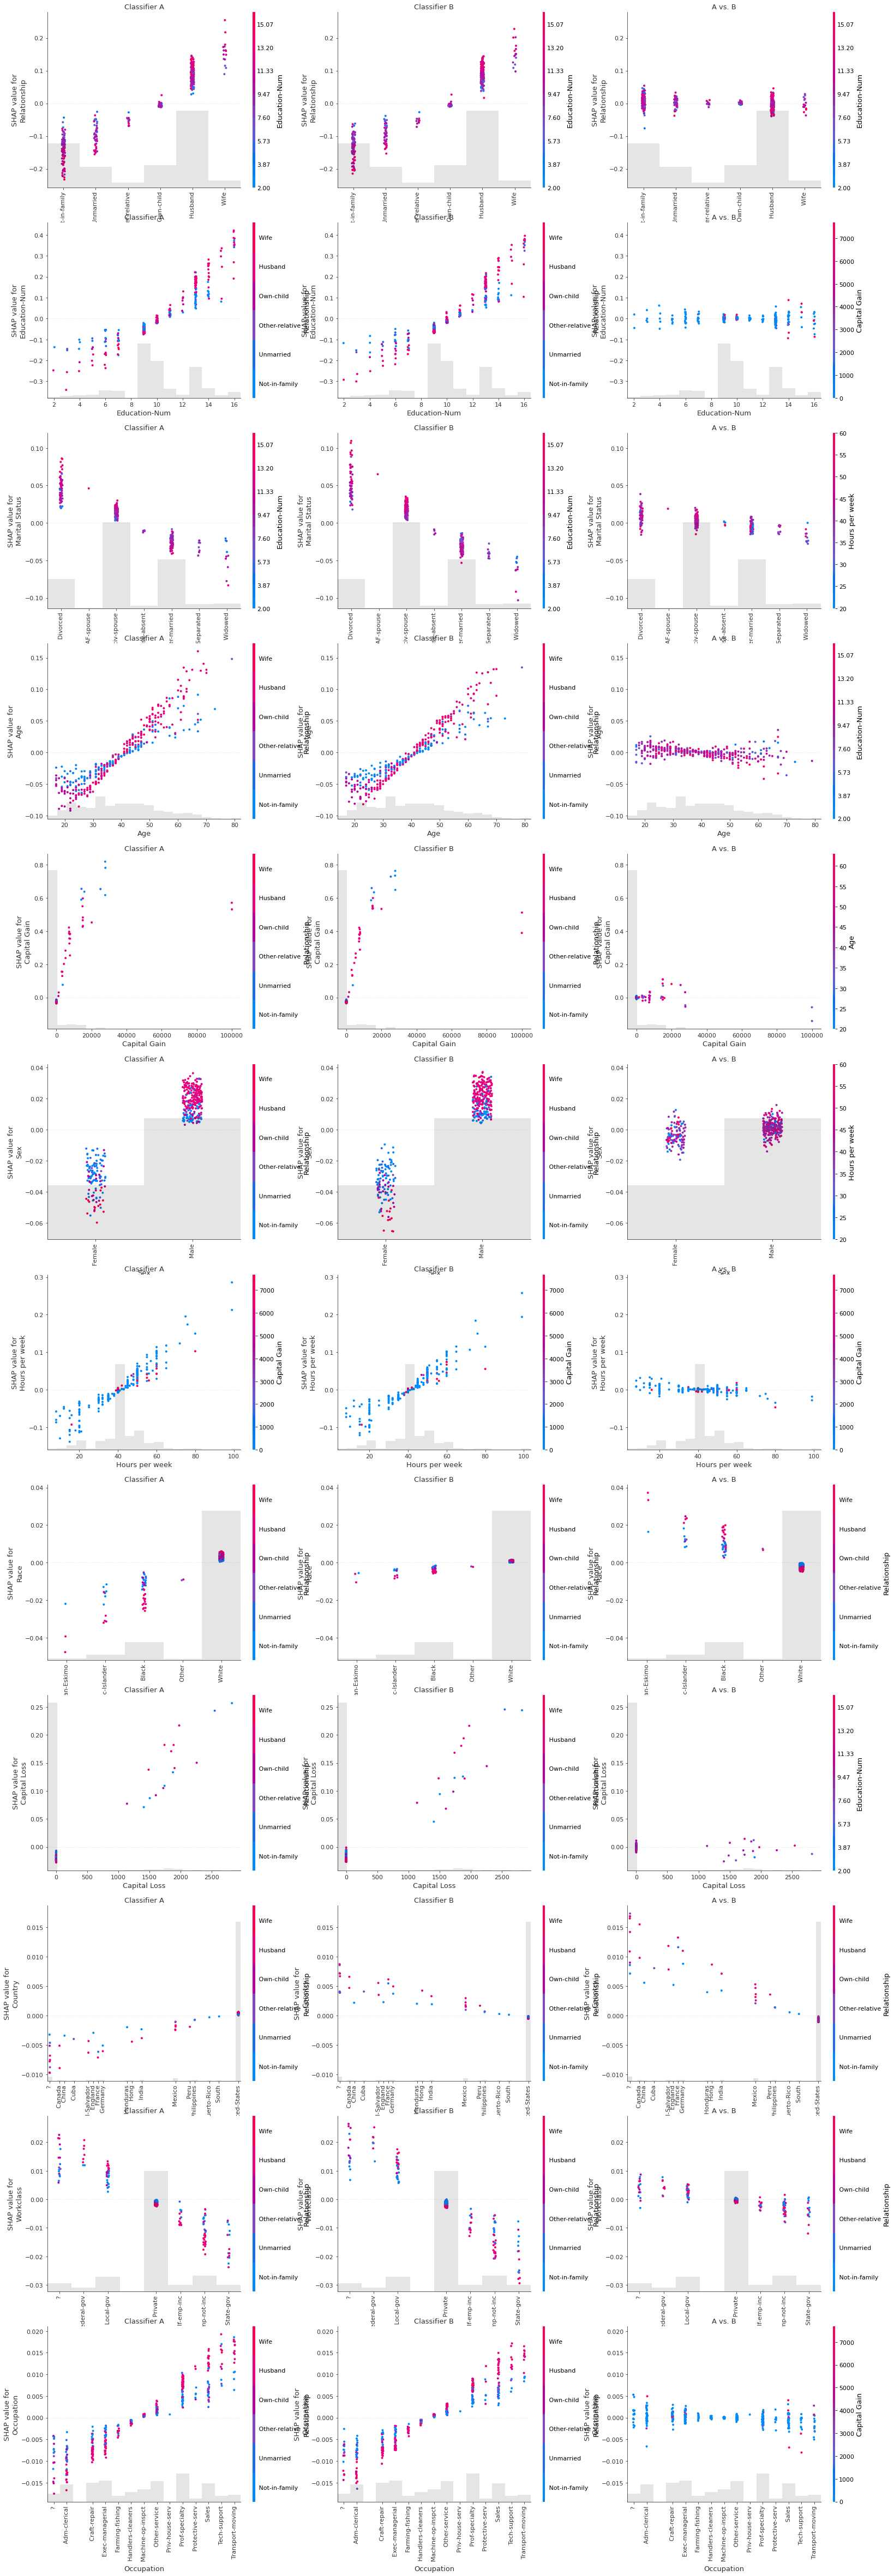

In [9]:
n_columns = 3
n_rows = n_features
fig = plt.figure(figsize=(9*n_columns, 7*n_rows))
i = 1
for feature in feature_names[feature_order]:
    ax = fig.add_subplot(n_rows, n_columns, i)
    plot.shap_scatter(shap_proba_a, feature, 'Classifier A', ax=ax)
    plot.shap_scatter(shap_proba_b, feature, 'Classifier B', ax=fig.add_subplot(n_rows, n_columns, i+1, sharey=ax))
    plot.shap_scatter(shap_proba_a_vs_b, feature, 'A vs. B', ax=fig.add_subplot(n_rows, n_columns, i+2, sharey=ax))
    i += n_columns
plt.show()

### Stacked SHAP Explanations, Clustered by Similarity

In [10]:
order = plot.shap_force(shap_proba_a, 'A')
plot.shap_force(shap_proba_b, 'B', ordering=order)
plot.shap_force(shap_proba_a_vs_b, 'A vs. B', ordering=order);

### Hierarchically Clustered SHAP Values

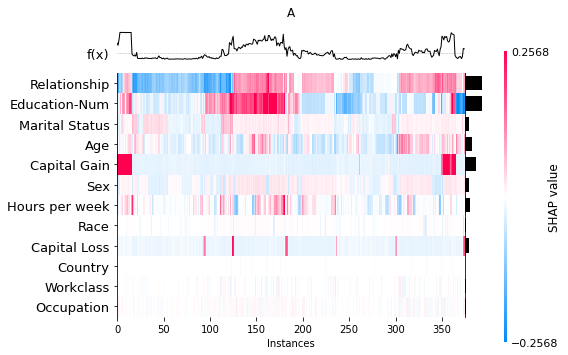

In [11]:
plot.shap_heatmap(shap_proba_a, 'A', feature_order)

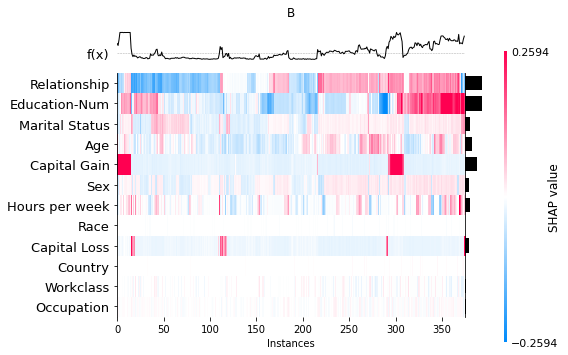

In [12]:
plot.shap_heatmap(shap_proba_b, 'B', feature_order)

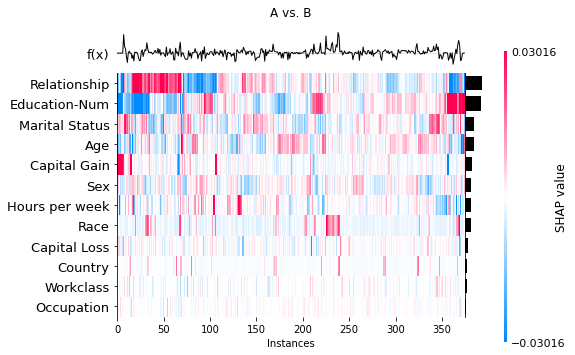

In [13]:
plot.shap_heatmap(shap_proba_a_vs_b, 'A vs. B', feature_order)